In [3]:
import shutil
import os
import random
from pathlib import Path
from IPython.core.debugger import set_trace

import geopandas as gpd
import pandas as pn
import numpy as np
import rasterio
from rasterio.windows import from_bounds
from rasterio.plot import show
from rasterio.plot import reshape_as_image
# import solaris as sol
# from solaris.data import data_dir
# from solaris.vector.polygon import convert_poly_coords, get_overlapping_subset

import matplotlib.pyplot as plt
from matplotlib import patches

from tqdm.notebook import tqdm
from shapely.geometry import Polygon, box
from shapely.ops import unary_union
%config Completer.use_jedi = False

In [4]:
gdf = gpd.read_file("../test_bboxes/test_bbox_rev.shp").explode()  # explode to make multipolygon single polygon

In [5]:
gdf.head()

,,MAPA,DELEGACIO,MUNICIPIO,MASA,PARCELA,HOJA,TIPO,CONSTRU,COORX,COORY,...,CONTROL,REFCAT,layer,path,width,height,area_1,perimeter,area_2,geometry
0,0,7016,7,13,017,00012,07013A,R,PI,500103.51,4353552.89,...,None,07013A01700012,campos_r,/home/biel/Documents/Master/TFM/cadastre/extra...,12.0800,9.2700,111.981600,42.700,14.0800,"POLYGON ((500097.106 4353547.872, 500097.106 4..."
1,0,7045,7,57,0001,034,00ED15A,D,PI,510662.84,4351960.40,...,None,000103400ED15A,santanyi_r,/home/biel/Documents/Master/TFM/cadastre/extra...,10.1000,10.9600,110.696000,42.120,12.1000,"POLYGON ((510656.790 4351953.920, 510656.790 4..."
2,0,7045,7,57,0001,044,00ED15A,D,PI,510445.68,4352158.87,...,None,000104400ED15A,santanyi_r,/home/biel/Documents/Master/TFM/cadastre/extra...,13.0972,14.1153,184.870907,54.425,15.0972,"POLYGON ((510437.941 4352150.659, 510437.941 4..."
3,0,7045,7,57,003,00418,07057A,R,PI,511570.07,4353834.66,...,None,07057A00300418,santanyi_r,/home/biel/Documents/Master/TFM/cadastre/extra...,3.3900,3.3800,11.458200,13.540,5.3900,"POLYGON ((511567.360 4353832.060, 511567.360 4..."
4,0,7045,7,57,003,00435,07057A,R,PI,511946.98,4353569.72,...,None,07057A00300435,santanyi_r,/home/biel/Documents/Master/TFM/cadastre/extra...,8.1600,4.7700,38.923200,25.860,10.1600,"POLYGON ((511941.730 4353565.940, 511941.730 4..."


In [23]:
def bboxes_in_image_bounds(imgs: str, bboxes: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    """returns bbox that are in image bounds"""
    with rasterio.open(imgs) as src:
        bounds = src.bounds
    sindex = bboxes.sindex
    intersectors = list(sindex.intersection(bounds))
    return bboxes.iloc[intersectors]

In [24]:
img1 = "/media/biel/SharedHDD/Master/TFM/ortos/PNOA_MA_OF_ETRS89_HU31_h50_0698_test.tif"
bbox0698 = bboxes_in_image_bounds(img1, gdf)
img2 = "/media/biel/SharedHDD/Master/TFM/ortos/PNOA_MA_OF_ETRS89_HU31_h50_0724_test.tif"
bbox0724 = bboxes_in_image_bounds(img2, gdf)

In [25]:
gdf = bbox0698.append(bbox0724, ignore_index=True)

In [27]:
# filter pools added before 2019 since ortofotos are 2018-2019
gdf = gdf[gdf["FECHAALTA"] < 20190101]

```
from solaris.tile.raster_tile import RasterTiler
from solaris.tile.vector_tile import VectorTiler

rtiler = RasterTiler(dest_dir="yolo_data/tiles/", src_tile_size=(512, 512), verbose=True, nodata=0)
```

```
# skip images that have 90% of nodata
rtiler.tile(img1, nodata_threshold=0.9)
rtiler.tile(img2, nodata_threshold=0.9)
```

In [ ]:
from itertools import product
import rasterio as rio
from rasterio import windows


def overlapping_windows(src, overlap, width, height, boundless=False):
    """"width & height not including overlap i.e requesting a 256x256 window with 
        1px overlap will return a 258x258 window (for non edge windows)"""
    offsets = product(range(0, src.meta['width'], width), range(0, src.meta['height'], height))
    big_window = windows.Window(col_off=0, row_off=0, width=src.meta['width'], height=src.meta['height'])
    for col_off, row_off in offsets:

        window = windows.Window(
            col_off=col_off - overlap,
            row_off=row_off - overlap,
            width=width + overlap * 2,
            height=height + overlap * 2)

        if boundless:
            yield window
        else:
            yield window.intersection(big_window)

            
def bbox_to_yolo(box: tuple, size: tuple=(512, 512)) -> tuple:
    """Converts bounding box coordinates (minx, miny, maxx, maxy) to yolo (x, y, w, h)"""
    dw = 1./size[0]
    dh = 1./size[1]
    x = ((box[0] + box[2])/2.0) * dw
    y = ((box[1] + box[3])/2.0) * dh
    w = (box[2] - box[0]) * dw
    h = (box[3] - box[1]) * dh
    return (x,y,w,h)


def trim_box(box: tuple, size: tuple=(512, 512)) -> tuple:
    """trims box coordinates (minx, miny, maxx, maxy) to the images edges given the image size (w, h)"""
    x0, y0, x1, y1 = box
    w, h = size
    c_x0, c_x1 = np.clip([x0, x1], 0, w)
    c_y0, c_y1 = np.clip([y0, y1], 0, h)
    return c_x0, c_y0, c_x1, c_y1

def get_window_bboxes(gdf, window, transform):
    bounds = rasterio.windows.bounds(window, transform)
    intersectors = list(gdf.sindex.intersection(bounds))
    if intersectors:
        set_trace()
    overlaps = gdf.iloc[intersectors]
    yolo_coords = []
    if not overlaps.empty:
        for geom in overlaps.geometry:
            pix_coords = convert_poly_coords(geom, affine_obj=transform, inverse=True)
            yolo_coords.append(bbox_to_yolo(trim_box(pix_coords.bounds)))
    return yolo_coords


def write_yolo_label(fname, coords):
    lines = ["0 " + " ".join(map(str, c)) for c in coords]
    with open(fname, "w") as f:
        f.writelines(lines)

In [31]:
def make_yolo_data(img: str, gdf):
    with rasterio.open(img) as src:
        base_name = Path(img1).name.split(".tif")[0]
        i = 0
        for window in overlapping_windows(src, 30, 452, 452, boundless=True):

            # get the window transform matrix
            transform = rasterio.windows.transform(window, src.transform)
            dst_name = f"{base_name}_{int(transform[2])}_{int(transform[5])}"
            dst_img = f"yolo_data/tiles/{dst_name}.tif"
            kwargs = src.meta.copy()
            kwargs.update({
                'height': window.height,
                'width': window.width,
                'transform': transform
            })
            with rasterio.open(dst_img, 'w', **kwargs) as dst:
                dst_data = src.read(window=window)
                dst.write(dst_data)
#             # get pool bboxes for this window
#             yolo_coords = get_window_bboxes(gdf, window, transform)
#             print(yolo_coords)
#             if yolo_coords:
#                 dst_label = f"yolo_data/labels/{dst_name}.txt"
#                 write_yolo_label(dst_label, yolo_coords)
#                 # copy this image to images/ to send to training yolo
#                 shutil.copy(dst_img, f"yolo_data/images/{dst_name}.tif")

In [32]:
make_yolo_data(img1, gdf)

In [33]:
tiles = list(Path("yolo_data/tiles/").glob("*.tif"))

In [47]:
yolo_coords = []
imgs_w_pools = []
for im in tiles:
    with rasterio.open(im) as src:
        sub = get_overlapping_subset(gdf, src)
        if not sub.empty:
            for geom in sub.geometry:
                imgs_w_pools.append(im)
                pix_coords = convert_poly_coords(geom, raster_src=src, inverse=True)
                yolo_coords.append(bbox_to_yolo(trim_box(pix_coords.bounds)))

In [48]:
seen = set()
for im, coords in zip(imgs_w_pools, yolo_coords):
    f_name = im.name.split(".tif")[0] + ".txt"
    # set append mode if file already exists -> more than one pool per image
    if f_name in seen:
        mode = "a"
    else:
        mode = "w"
    with open(f"yolo_data/labels/{f_name}", mode) as f:
        f.write("0 " + " ".join(map(str, coords)) + "\n")
    seen.add(f_name)

In [144]:
names_pools = set(n.name.split(".txt")[0] for n in Path("yolo_data/labels/").glob("*.txt"))

In [143]:
imgs = Path("yolo_data/tiles/").glob("*.tif")

In [145]:
for img in imgs:
    name = img.name.split(".tif")[0]
    if  name in names_pools:
        shutil.copy(img, "yolo_data/images/"+name+".tif")

In [151]:
def plot_yolo_box(img, boxes, ax):
    coord_boxes = []
    s = 512
    for x, y, w, h in boxes:
        x1, x2 = (x - (w/2))*s, (x + (w/2))*s
        y1, y2 = (y - (h/2))*s, (y + (h/2))*s
        coord_boxes.append([x1, y1, x2, y2])
    
    if not ax:
        _, ax = plt.subplots(1, figsize=(10,10))
    ax.imshow(reshape_as_image(img))
    for x1, y1, x2, y2 in coord_boxes:
        box_w = x2 - x1
        box_h = y2 - y1
        # Create a Rectangle patch
        bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, edgecolor="red", facecolor="none")
        # Add the bbox to the plot
        ax.add_patch(bbox)

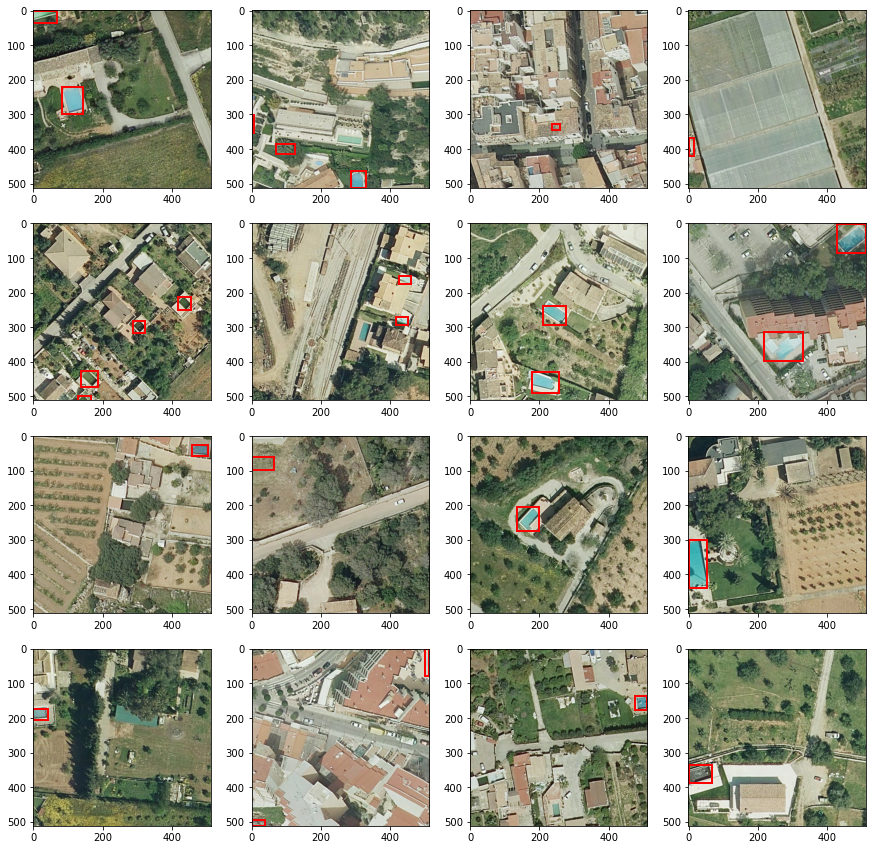

In [165]:
tiles = list(Path("yolo_data/images/").glob("*.tif"))
tiles_sub = random.sample(tiles, 16)
fig, axs = plt.subplots(4, 4, figsize=(15, 15))
for i, ax in enumerate(axs.ravel()):
    name = tiles_sub[i].name
    labelname =  f"yolo_data/labels/{name.split('.tif')[0]}.txt"
    with rasterio.open(str(tiles_sub[i])) as src:
        img = src.read()
        with open(labelname) as f:
            boxes = []
            for l in f.readlines():
                boxes.append([float(s) for s in l.split()][1:])
        plot_yolo_box(img, boxes, ax)